In [8]:
# import packages
import json
import xarray as xr
import dask
import numpy as np
import importlib

import modules
import setup_domain_func

import os

In [ ]:
import logging

In [ ]:
importlib.reload(setup_domain_func)
importlib.reload(modules)

In [2]:
# Get some ressourcers
client, cluster = modules.getCluster('fat', 1, 25)
    
# Do the memory magic...
client.amm.start() 
    
# Write some info about the cluster
print(client.scheduler_info)

<bound method Client.scheduler_info of <Client: 'tcp://172.27.80.110:40000' processes=0 threads=0, memory=0 B>>


In [7]:
client

<Client: 'tcp://172.27.80.110:40000' processes=25 threads=75, memory=745.00 GiB>

In [ ]:
# Read the domain configuration from the respective JSON
with open('conf/domain_config.json', 'r') as j:
    domain_config = json.loads(j.read())

# Read the global configuration from the respective JSON --> Add this as further input parameter
with open('conf/global_config.json', 'r') as j:
    global_config = json.loads(j.read())

# Read the variable configuration from the respective JSON
with open('conf/variable_config.json', 'r') as j:
    variable_config = json.loads(j.read())

In [ ]:
domain_config = domain_config['germany']

In [ ]:
# Setup some logging
logging.basicConfig(filename=f"logs/{domain_config['prefix']}_setup_domain.log", encoding='utf-8', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

In [ ]:
variable_config = { key:value for key,value in variable_config.items() if key in domain_config['variables']}

In [ ]:
dir_dict = setup_domain_func.set_and_make_dirs(domain_config)

In [ ]:
grd_fle = setup_domain_func.create_grd_file(domain_config, dir_dict)

In [ ]:
syr_calib = domain_config["syr_calib"]
eyr_calib = domain_config["eyr_calib"]

In [ ]:
for month in [7, 10, 11, 12]:
    
    results = []
    
    month_str = str(month).zfill(2)

    for year in range(1988, eyr_calib + 1):
        
        results.append(setup_domain_func.prepare_forecast_dask(domain_config, variable_config, dir_dict, year, month_str))
    
    try:
        dask.compute(results)
        logging.info(f"Slicing for month {month_str} for all years from {syr_calib} to {eyr_calib} successful")
    except:
        logging.warning(f"Something went wrong during slicing for {month_str}")
    

In [ ]:
for month in [7, 6, 9]:
    print(month)

In [36]:
ds = xr.open_dataset('/pd/data/regclim_data/gridded_data/seasonal_predictions/seas5/raw/2022/09/ECMWF-seas5_03deg_daily_tp_202209.nc')

In [37]:
ds

<xarray.Dataset>
Dimensions:  (time: 10965, lon: 1296, lat: 640)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-02 2022-09-02 ... 2023-04-04
  * lon      (lon) float64 0.0 0.2778 0.5556 0.8333 ... 358.9 359.2 359.4 359.7
  * lat      (lat) float64 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
Data variables:
    var228   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Sep 09 08:26:18 2022: cdo -O -f nc4 -k grid -z zip_6 -s...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

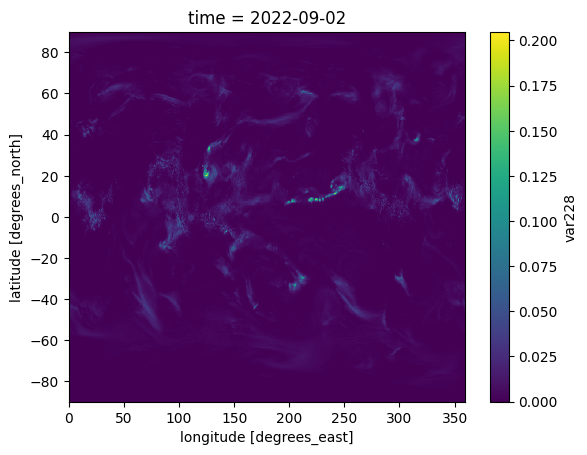

In [47]:
ds.var228[0,:,:].plot()